In [27]:
!nvidia-smi

Fri Jan 12 17:07:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0              33W /  70W |   2119MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 1. Importing libraries and data

In [28]:
!pip install ultralytics

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
import cv2
import os
import json
from random import choice
import torch
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from datetime import datetime
from torchvision import models, transforms
import albumentations as A
from tqdm import tqdm
from ultralytics import YOLO
import warnings
warnings.filterwarnings("ignore")

In [31]:
# Get a list of file names
images_special_car = listdir('/kaggle/input/dataset-for-classification-of-specialty-cars/Dataset/Spesial_car/') 
image_rest = listdir('/kaggle/input/dataset-for-classification-of-specialty-cars/Dataset/Rest/')

# Transfer them to the dataframe
data_special_car = pd.DataFrame(images_special_car, columns=['src'])
data_rest = pd.DataFrame(image_rest, columns=['src'])

# Add target attributes
data_special_car['label'] = 1 # Specialty cars
data_rest['label'] = 0 # Simple pictures

# Объединяем 
data = pd.concat([data_special_car, data_rest], ignore_index=True)
data # Let's take a look at the resulting dataframe

src  label
0      0664.jpg      1
1      0106.jpg      1
2      0375.jpg      1
3     00614.jpg      1
4     0223.jpeg      1
...         ...    ...
3037    599.jpg      0
3038   0269.jpg      0
3039   0222.png      0
3040    040.jpg      0
3041    147.jpg      0

[3042 rows x 2 columns]

In [32]:
data['label'].value_counts() / data.shape[0] * 100 # Распределение целевого признака

label
0    50.591716
1    49.408284
Name: count, dtype: float64

You can see that there are more photos without specialty autos in the dataset

# 2. Augmentation of photos and their subsequent processing

## 2.1. Description of augmentation rules

In [33]:
# Описываем приёмы аугментации
transform1 = A.Compose([
    A.HorizontalFlip(p=0.05), # Поворот по вертикали
    A.Blur(p=0.25) # Эффект размытия на изображении
])
transform2 = A.Compose([
    A.HorizontalFlip(p=0.05), # Поворот по вертикали
    A.ToGray() # Перевод изображения в чб изображение
])
transform3 = A.Compose([
    A.HorizontalFlip(p=0.5), # Поворот по вертикали
    A.RandomContrast(p=0.25) # Увеличение контарстности
])
transform4 = A.Compose([
    A.HorizontalFlip(p=0.05), # Поворот по вертикали
    A.JpegCompression(p=0.25) # Добавление шума на изображение
])

## 2.2. Processing of each photo and their augmentation

100%|██████████| 3042/3042 [01:56<00:00, 26.18it/s]


CPU times: user 1min 51s, sys: 6.19 s, total: 1min 58s
Wall time: 2min


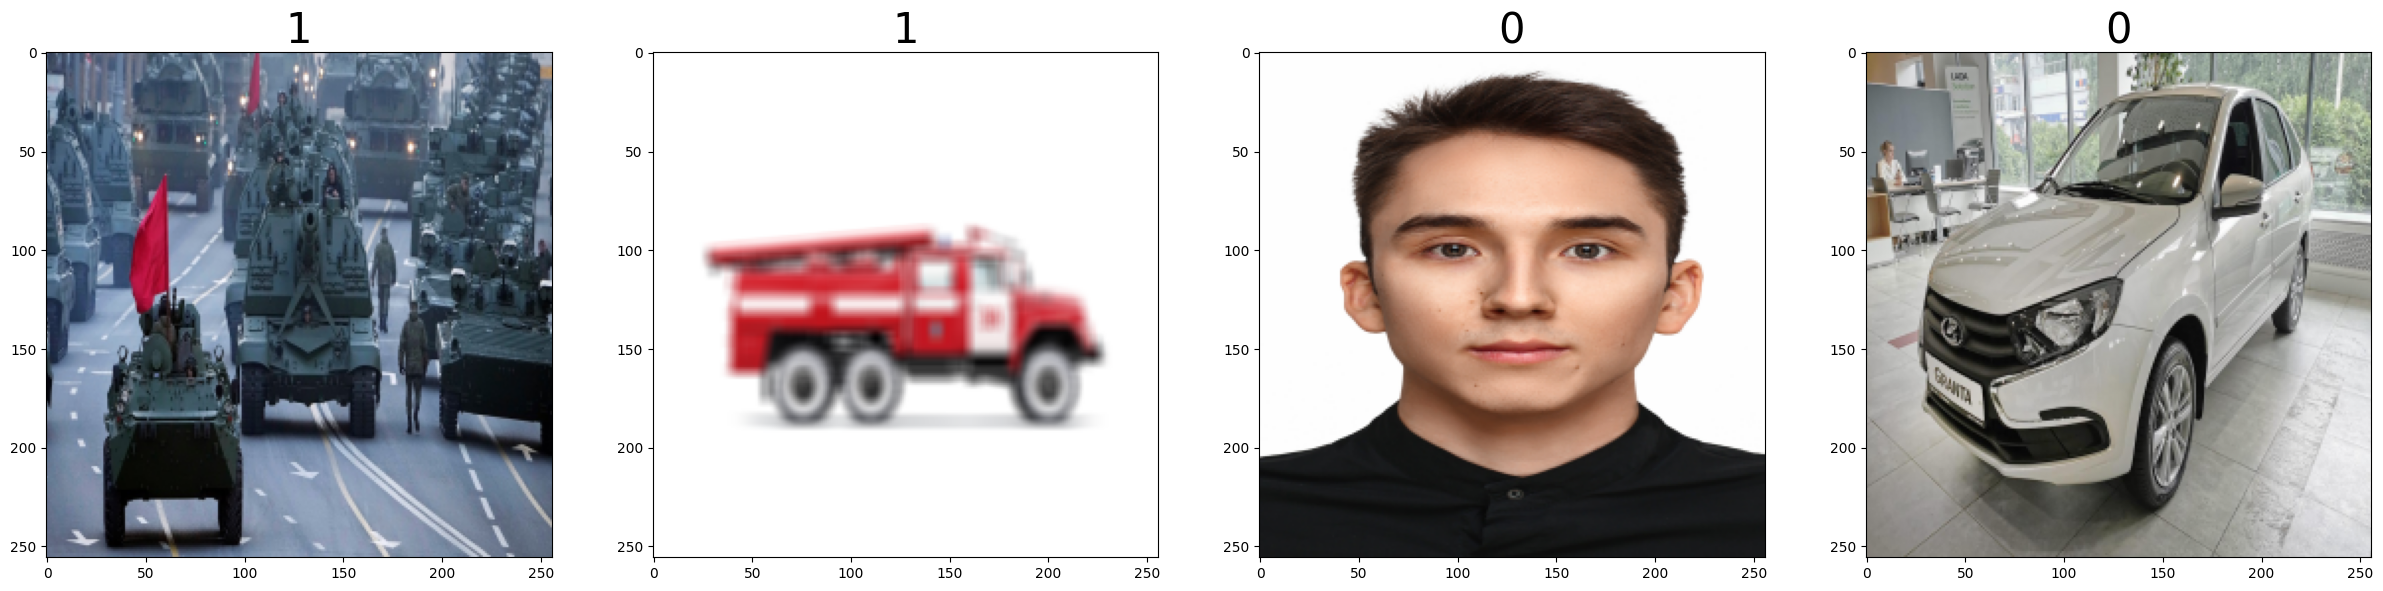

In [34]:
%%time
X = [] # Photographs in matrix format
y = [] # Classes of photographs
for i in tqdm(range(len(data))):
    image = data.loc[i,'src'] # Get the path to the image
    if (data.loc[i, 'label'] == 1): # If there's a special car in the picture
        image = cv2.imread('/kaggle/input/dataset-for-classification-of-specialty-cars/Dataset/Spesial_car/'+image, cv2.IMREAD_COLOR) 
    else: # If it's not a special car in the picture
        image = cv2.imread('/kaggle/input/dataset-for-classification-of-specialty-cars/Dataset/Rest/'+image, cv2.IMREAD_COLOR) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert the color palette of the photo from BGR to RGB 
    image = cv2.resize(image, dsize=(256, 256), interpolation=cv2.INTER_AREA) # Resize the image 
    X.append(image) # Adding to the dataset

    # We're augmenting the photos
    transform = None
    transform_old = None
    for _ in range(2):
        while True:
            transform = choice([transform1, transform2, transform3, transform4])
            if transforms != transform_old:
                transformed_image = transform(image=image)
                X.append(transformed_image["image"])
                transform_old = transform
                break
    # Add labels for images
    for _ in range(3):
        y.append(data.loc[i, 'label'])

# Normalize the data
X_torch = np.array(X)
X_torch = X_torch.astype('float32')
X_torch = X_torch / 255.0
X_torch = X_torch.reshape(-1,3, 256, 256)
y_torch = np.array(y).reshape(-1)

# Let's take a couple of examples of the resulting photos
fig, axes = plt.subplots(1, 4, figsize=(30,15))
for i in range(0, 4):
    axes[i].imshow(X[i*y_torch.size//4])
    axes[i].set_title(y[i*y_torch.size//4], fontsize=30)

In [35]:
print(f"Number of Iterations: {X_torch.shape[0]} | Number of tags {y_torch.size}")
print(f"The number of photos after augmentation increased {round(y_torch.size / data.shape[0], 3)} times to {y_torch.size} images")

Number of Iterations: 9126 | Number of tags 9126
The number of photos after augmentation increased 3.0 times to 9126 images


# 3. Neural network training
## 3.1. Formation of training and validation sample, translation of data into tensors.

In [8]:
# Let's define the possibility of photo processing on GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [9]:
# Form a new training and test sample
X_train, X_valid, y_train, y_valid = train_test_split(X_torch, y_torch, random_state=42)
# Let's convert all the data into tensors
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train)
X_valid_t = torch.from_numpy(X_valid).float()
y_valid_t = torch.from_numpy(y_valid)

# Generate datasets with samples
train_dataset = TensorDataset(X_train_t, y_train_t)
valid_dataset = TensorDataset(X_valid_t, y_valid_t)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

# Dictionary with selections
loaders = {"train": train_dataloader, "valid": valid_dataloader}

## 3.2. Functions for training, saving, visualizing models

In [10]:
def trainNeuralNetwork(model, loaders, name_model, max_epochs, epoch_patience):
    '''
    The function allows you to train a neural network model, store the weights on the computer and return the execution history
    Input:
        model - neural network model
        loaders - dictionary with samples
        name_model - model name
        max_epochs - maximum number of training epochs
        epoch_patience - number of epochs for early stopping of training (fight against overtraining)
    Output:
        best_model_roc - true and predicted values from the best model 
        loss_history - history of error by epochs during model training
        epoch_erly_stopping - epoch at which the early model stopping occurred
        best_model_accuracy - accuracy of the best model instance
        best_model_loss - loss of the best model instance
    '''
    print(f'Training of {name_model} neural network architecture')
    criterion = torch.nn.CrossEntropyLoss() # Error calculation
    optimizer = torch.optim.Adam(model.parameters()) # Calculating the loss gradient
    scheduler = StepLR(optimizer, step_size=25, gamma=0.1) 
    best_model = model # The best looking model
    best_model_loss = np.Inf # Loss at the best model
    best_model_accuracy = 0 # Accuracy with the best model  
    epoch_erly_stopping = 0 # The era of the early shutdown
    flag = False 
    col_not_best = 0 # Number of epochs unchanged
    loss_history = {"train": [], "valid": []}  # The history of model loss at each epoch
    best_model_roc = {"correct": [], "preds": []} # ROC curve calculation data of the best model 
    train_losses = [] # Loss on the training sample for each picture
    valid_losses = [] # Loss on the validation sample for each picture
    start_time = datetime.now() # Start time
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            roc = {"correct": [], "preds": []}
            for x_batch, y_batch in dataloader:
                # Transfer the data to the device
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                if k == "train":
                    model.train() # Putting the model in training 
                    optimizer.zero_grad() # Zero out the error gradients
                    outp = model(x_batch) # Getting answers from the model
                else:
                    model.eval() # Set the model to predict
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1) 
                correct = (preds == y_batch).sum()  # Number of correct answers
                all = preds.size(0) # Number of all responses
                epoch_correct += correct.item() # Number of photos correctly recognized
                epoch_all += all 
                loss = criterion(outp, y_batch) # Calculate the loss gradient
                if k == "train":
                    train_losses.append(loss.item()) 
                    loss.backward()
                    optimizer.step()
                else:
                    roc["correct"].append([i.item() for i in y_batch])
                    roc["preds"].append([i.item() for i in preds])
                    valid_losses.append(loss.item()) 
                    
            if k == "valid":
                # Calculate the weighted average of the samples
                train_loss = np.average(train_losses) 
                valid_loss = np.average(valid_losses) 
                
                # Save the weighted average error to history
                loss_history["train"].append(abs(train_loss))
                loss_history["valid"].append(abs(valid_loss))
                print(f"[{epoch+1:>3}/{max_epochs:>3}] loss train: {abs(train_loss):.5f} | loss valid: {abs(valid_loss):.5f}")

                # Checking for neural network error reduction on validation
                if abs(round(best_model_loss, 5)) > abs(round(valid_loss, 5)):
                    # Saving model information and weights
                    col_not_best = 0 
                    best_model = model
                    epoch_erly_stopping = epoch
                    best_model_accuracy = epoch_correct/epoch_all 
                    best_model_roc = roc
                    torch.save(best_model, f"checkpoint_{name_model}.pt")
                    print(f"Validation loss decreased ({abs(best_model_loss):.5f} --> {abs(valid_loss):.5f}).  Saving model ...")
                    best_model_loss = abs(valid_loss)
                           
                else:
                    # If X number of epochs no progress, stop learning
                    if col_not_best + 1 >= epoch_patience:
                        print("Early stopping!")
                        flag = True
                        break
                    else:
                        col_not_best += 1
                        print(f"EarlyStopping counter: {col_not_best} out of {epoch_patience}")    
        scheduler.step()
        if flag:
            break
    roc = {'correct': [], 'preds': []}
    for sampling in ['correct', 'preds']:
        for index in range(len(best_model_roc[sampling])):
            for item in best_model_roc[sampling][index]:
                roc[sampling].append(item)
    best_model_roc = roc
    torch.save(best_model, f"{name_model}.pth") # Saving the complete model on the computer
    print(f'Program execution time: {datetime.now() - start_time}')
    return best_model_roc, loss_history, epoch_erly_stopping, best_model_accuracy, best_model_loss

In [11]:
def visualizationLearning(name_model, epoch_stopping, roc, loss_history ):
    '''
    The function allows to visualize the training history of the neural network model and to show the early errors
    Input:
        name_model - model name 
        epoch_stopping - epoch at which the early stopping occurred 
        roc - true and predicted values
        loss_history - history of model losses at each epoch
    '''
    plt.figure(figsize=(21, 9))
    
    # Loss history image
    plt.subplot(1, 2, 1)
    plt.plot(loss_history["train"], label='Training sample')
    plt.plot(loss_history["valid"], label='Validation sample')
    plt.title(f'CrossEntropyLoss architecture {name_model}')
    plt.xlabel('Epoch')
    plt.ylabel('')
    plt.axvline(epoch_stopping, color='red', linestyle='--', label='EarlyStopping')
    plt.legend()
   
    # ROC curve image
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(roc['correct'], roc['preds'])
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(f'ROC Curves architecture {name_model}')
    plt.grid(True)

    # Save it to an image and render it
    plt.savefig(f'{name_model}.png',dpi=100)
    plt.show()

In [12]:
def visualizationNeuralNetworks(data, isEnhancement=False):
    '''
    The function allows you to visualize the accuracy of the neural network models at each epoch and put them all on the same graph
    Input:
        data - array containing dictionaries with data for each neural network
    The function allows visualizing the accuracy of neural network models at each of the epochs and placing all of them on one graph
    Input:
        data - array containing dictionaries with data for each neural network
    '''
    plt.figure(figsize=(21, 9))
    max_epoch = 0
    for item in data:
        # Loss history image
        plt.subplot(1, 2, 1)
        plt.plot(item['loss_history']['valid'], label=item['name'])
        plt.title('CrossEntropyLoss of neural networks')
        plt.xlabel('Epoch')
        plt.ylabel('CrossEntropyLoss')
        plt.legend()

        # ROC curve image
        plt.subplot(1, 2, 2)
        fpr, tpr, _ = roc_curve(item['roc_data']['correct'], item['roc_data']['preds'])
        area = auc(fpr, tpr)
        label_model = item['name']+ f' (area = {area:0.2f})'
        plt.plot(fpr, tpr, linewidth=2, label=label_model)
        plt.plot([0, 1], [0, 1], 'k--') 
        plt.title('ROC Curves of neural networks')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend()
        plt.grid(True)
    if isEnhancement:
        plt.savefig(f'{isEnhancement}.png', dpi=100)
    else:
        plt.savefig(f'visualizationNeuralNetworks.png', dpi=100)
    plt.show()

In [13]:
def addHistoryModels(name, roc, loss_history, loss, epoch_stopping ):
    '''
    The function allows you to write all information about model training to a json file
    Input:
        name - model name 
        roc - true and predicted values of the best model 
        loss_history - history of model losses at each of the epochs  
        accuracy - accuracy of the best model instance  
        loss - loss of the best model instance 
        epoch_stopping - epoch on which the early stopping occurred
    
    '''
    if 'data.json' not in os.listdir():
        json_data = [{'name': name,
                      'loss_history': loss_history,
                      'loss': loss,
                      'epoch_stopping':epoch_erly_stopping,
                      'roc_data': roc  
        }]
        with open('data.json', 'w') as file:
            json.dump(json_data, file)
    else:
        with open('data.json', 'r') as file:
            json_data = json.load(file)  # Load the contents of the file into the dictionary
        isDublicate = False
        for i in range(len(json_data)):
            if json_data[i]['name'] == name:
                json_data[i] = {'name': name,
                    'loss_history': loss_history,
                    'loss': loss,
                    'epoch_stopping':epoch_erly_stopping,
                    'roc_data': roc     
                }
                print('Model training data successfully overwritten')
                isDublicate = True
                break
        else:
            json_data.append({
                'name': name,        
                'loss_history': loss_history,
                'loss': loss,
                'epoch_stopping':epoch_erly_stopping,
                'roc_data': roc         
            })
            print('Model training data successfully recorded')
    with open('data.json', 'w') as file:
            json.dump(json_data, file)

In [14]:
max_epochs_models = 100 # Maximum number of epochs
epoch_patience_models = 15 # The tolerance of the ages to an early halt

## 3.2. Training of MobileNetV3Large neural network architecture

Training of MobileNetV3Large neural network architecture

[  1/100] loss train: 0.53989 | loss valid: 0.68986

Validation loss decreased (inf --> 0.68986).  Saving model ...

[  2/100] loss train: 0.46841 | loss valid: 0.69853

EarlyStopping counter: 1 out of 15

[  3/100] loss train: 0.41369 | loss valid: 0.73761

EarlyStopping counter: 2 out of 15

[  4/100] loss train: 0.37022 | loss valid: 0.91277

EarlyStopping counter: 3 out of 15

[  5/100] loss train: 0.33385 | loss valid: 0.90823

EarlyStopping counter: 4 out of 15

[  6/100] loss train: 0.31216 | loss valid: 0.80942

EarlyStopping counter: 5 out of 15

[  7/100] loss train: 0.28796 | loss valid: 0.76248

EarlyStopping counter: 6 out of 15

[  8/100] loss train: 0.26486 | loss valid: 0.71638

EarlyStopping counter: 7 out of 15

[  9/100] loss train: 0.24510 | loss valid: 0.68566

Validation loss decreased (0.68986 --> 0.68566).  Saving model ...

[ 10/100] loss train: 0.22684 | loss valid: 0.65539

Validation loss decreased (0

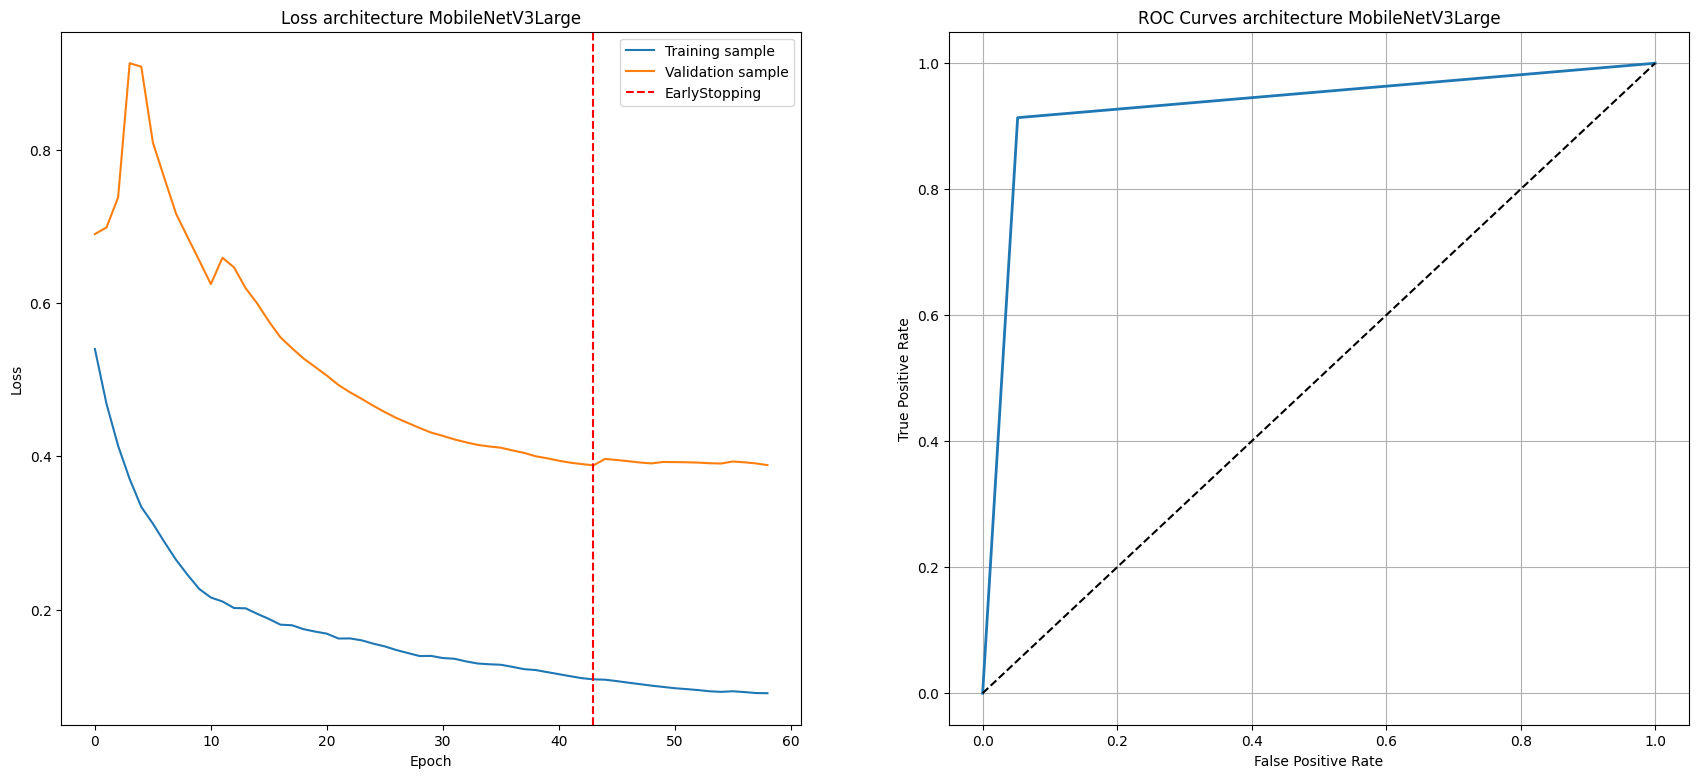

In [15]:
model = models.mobilenet_v3_large() # Loading structure and weights
model.classifier = torch.nn.Linear(960, 1) # Prediction layer replacement
model.to(device)
name_model = 'MobileNetV3Large'
roc, loss_history, epoch_erly_stopping, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del model ,loss_history, epoch_erly_stopping, loss, name_model, roc

## 3.3. Training of EffecientNet_B0 neural network architecture

Training of EffecientNet_B0 neural network architecture

[  1/100] loss train: 0.64354 | loss valid: 1.02021

Validation loss decreased (inf --> 1.02021).  Saving model ...

[  2/100] loss train: 0.57260 | loss valid: 1.37456

EarlyStopping counter: 1 out of 15

[  3/100] loss train: 0.53566 | loss valid: 1.06073

EarlyStopping counter: 2 out of 15

[  4/100] loss train: 0.50594 | loss valid: 0.89499

Validation loss decreased (1.02021 --> 0.89499).  Saving model ...

[  5/100] loss train: 0.47590 | loss valid: 0.79273

Validation loss decreased (0.89499 --> 0.79273).  Saving model ...

[  6/100] loss train: 0.44838 | loss valid: 0.72676

Validation loss decreased (0.79273 --> 0.72676).  Saving model ...

[  7/100] loss train: 0.43565 | loss valid: 0.69430

Validation loss decreased (0.72676 --> 0.69430).  Saving model ...

[  8/100] loss train: 0.42191 | loss valid: 0.64280

Validation loss decreased (0.69430 --> 0.64280).  Saving model ...

[  9/100] loss train: 0.40322 | loss valid:

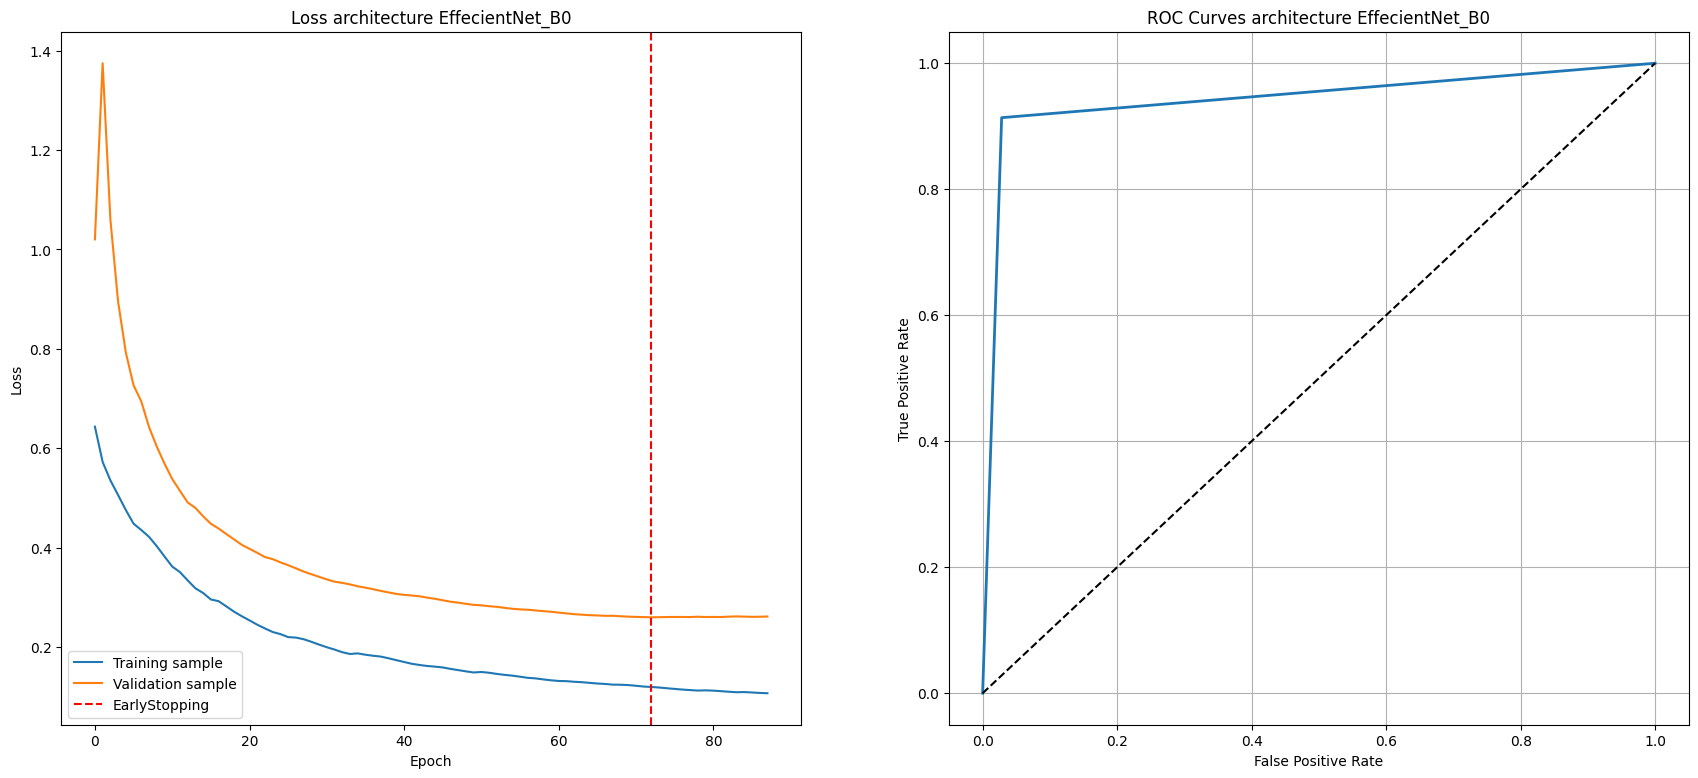

In [16]:
model = models.efficientnet_b0() # Loading structure and weights
model.classifier = torch.nn.Linear(1280, 1) # Prediction layer replacement
model.to(device)
name_model = 'EffecientNet_B0'
roc, loss_history, epoch_erly_stopping, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del model, loss_history, epoch_erly_stopping, loss, name_model, roc

## 3.4. Training of MNASNET1_3 neural network architecture

Training of MNASNET1_3 neural network architecture

[  1/100] loss train: 0.57149 | loss valid: 0.69015

Validation loss decreased (inf --> 0.69015).  Saving model ...

[  2/100] loss train: 0.50242 | loss valid: 0.68990

Validation loss decreased (0.69015 --> 0.68990).  Saving model ...

[  3/100] loss train: 0.45360 | loss valid: 0.69113

EarlyStopping counter: 1 out of 15

[  4/100] loss train: 0.41251 | loss valid: 0.69506

EarlyStopping counter: 2 out of 15

[  5/100] loss train: 0.38249 | loss valid: 0.69910

EarlyStopping counter: 3 out of 15

[  6/100] loss train: 0.34976 | loss valid: 0.70406

EarlyStopping counter: 4 out of 15

[  7/100] loss train: 0.32498 | loss valid: 0.71045

EarlyStopping counter: 5 out of 15

[  8/100] loss train: 0.30254 | loss valid: 0.71759

EarlyStopping counter: 6 out of 15

[  9/100] loss train: 0.28174 | loss valid: 0.72818

EarlyStopping counter: 7 out of 15

[ 10/100] loss train: 0.26422 | loss valid: 0.74125

EarlyStopping counter: 8 out of 15

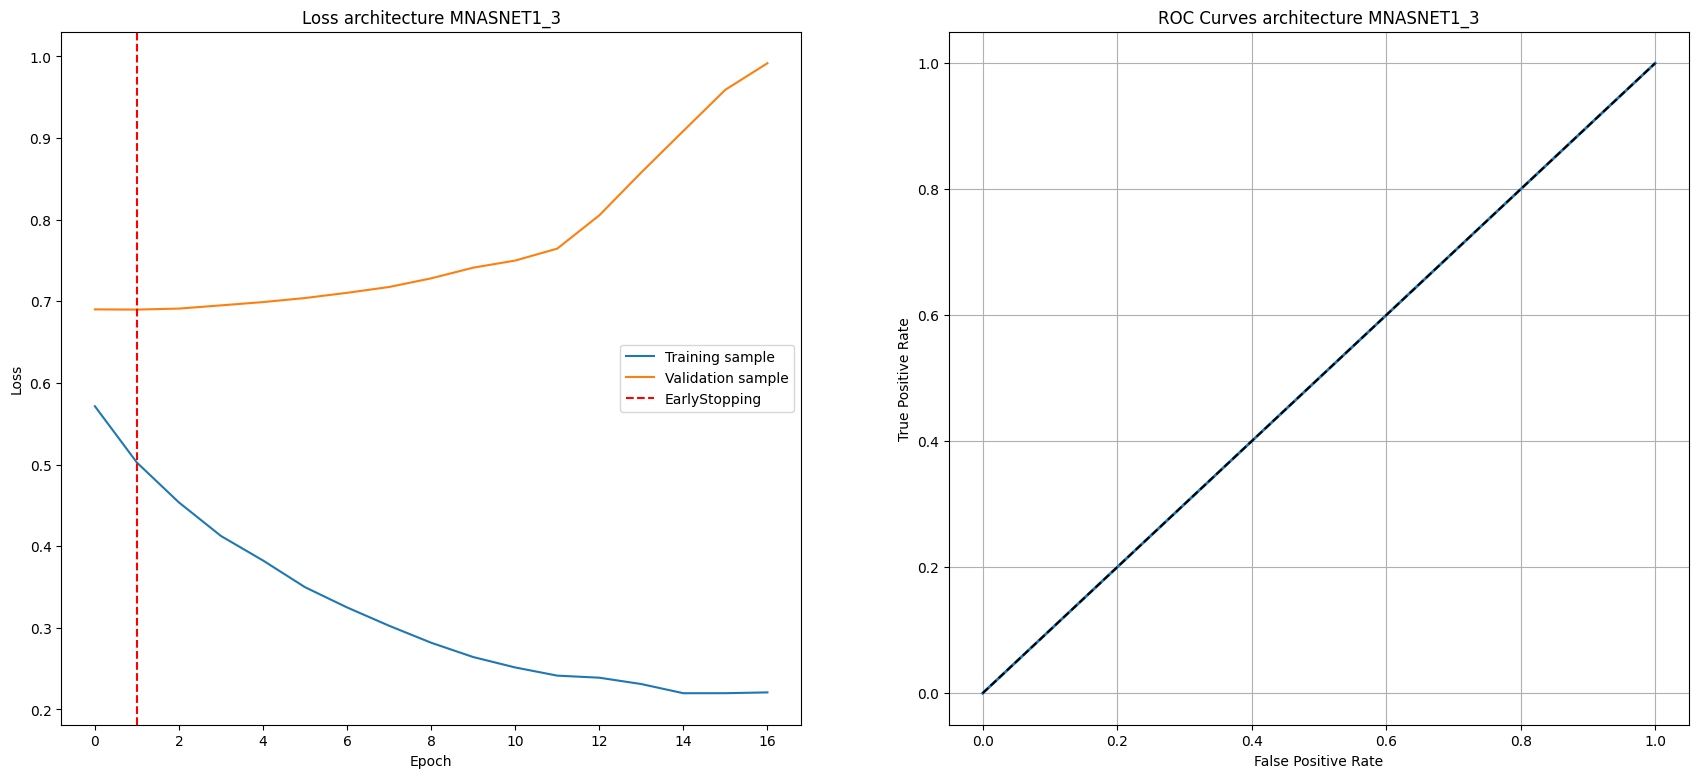

In [17]:
model = models.mnasnet1_3() # Loading structure and weights
model.classifier =  torch.nn.Linear(1280, 1) # Prediction layer replacement
model.to(device)
name_model = 'MNASNET1_3'
roc, loss_history, epoch_erly_stopping, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del model, loss_history, epoch_erly_stopping, loss, name_model, roc

## 3.5. Training of the ResNet18 neural network architecture

Training of ResNet18 neural network architecture

[  1/100] loss train: 0.62142 | loss valid: 0.62498

Validation loss decreased (inf --> 0.62498).  Saving model ...

[  2/100] loss train: 0.56208 | loss valid: 0.63795

EarlyStopping counter: 1 out of 15

[  3/100] loss train: 0.52771 | loss valid: 0.60653

Validation loss decreased (0.62498 --> 0.60653).  Saving model ...

[  4/100] loss train: 0.50602 | loss valid: 0.64660

EarlyStopping counter: 1 out of 15

[  5/100] loss train: 0.49584 | loss valid: 0.61168

EarlyStopping counter: 2 out of 15

[  6/100] loss train: 0.48014 | loss valid: 0.58139

Validation loss decreased (0.60653 --> 0.58139).  Saving model ...

[  7/100] loss train: 0.46733 | loss valid: 0.55381

Validation loss decreased (0.58139 --> 0.55381).  Saving model ...

[  8/100] loss train: 0.45737 | loss valid: 0.53668

Validation loss decreased (0.55381 --> 0.53668).  Saving model ...

[  9/100] loss train: 0.44774 | loss valid: 0.51609

Validation loss decreased (0.

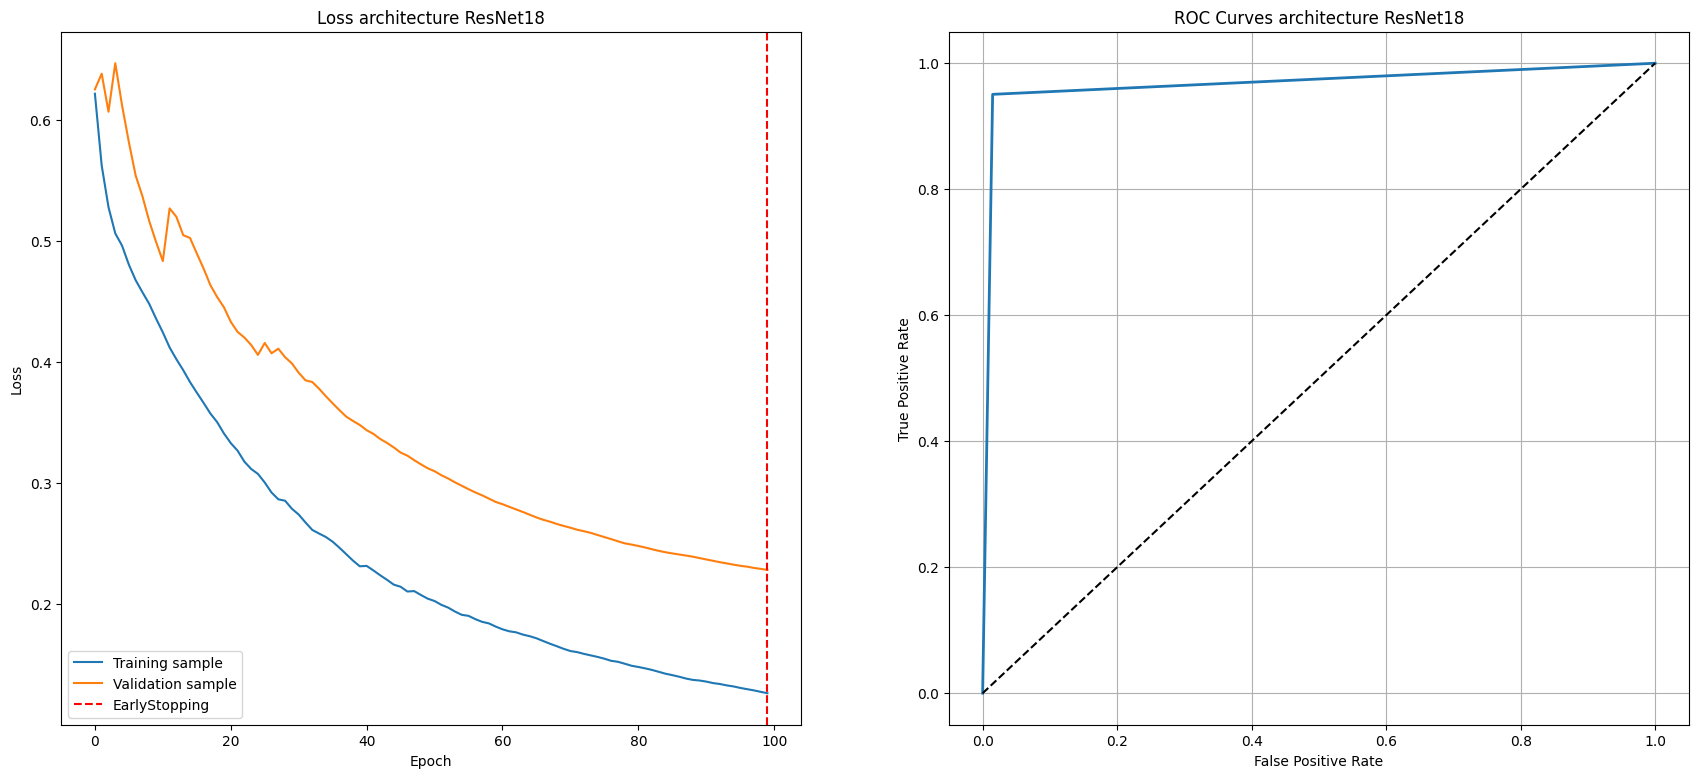

In [18]:
model = models.resnet18() # Loading structure and weights
model.fc = torch.nn.Linear(512, 1) # Prediction layer replacement
model.to(device)
name_model = 'ResNet18'
roc, loss_history, epoch_erly_stopping, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del model, loss_history, epoch_erly_stopping, loss, name_model, roc

## 3.6. Training of YOLOv5 neural network architecture

Using cache found in C:\Users\k1rsn/.cache\torch\hub\ultralytics_yolov5_master

YOLOv5  2023-12-18 Python-3.11.5 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)



Fusing layers... 

Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs

WARNING  YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


Training of YOLOv5s neural network architecture

[  1/100] loss train: 0.58014 | loss valid: 0.53922

Validation loss decreased (inf --> 0.53922).  Saving model ...

[  2/100] loss train: 0.54873 | loss valid: 0.52739

Validation loss decreased (0.53922 --> 0.52739).  Saving model ...

[  3/100] loss train: 0.53048 | loss valid: 0.51943

Validation loss decreased (0.52739 --> 0.51943).  Saving model ...

[  4/100] loss train: 0.51772 | loss valid: 0.51435

Validation loss decreased (0.51943 --> 0.51435).  Saving model ...

[  5/100] loss train: 0.50804 | loss valid: 0.50917

Validation loss decreased (0.51435 --> 0.50917).  Saving model ...

[  6/100] loss train: 0.50133 | loss valid: 0.50512

Validation loss decreased (0.50917 --> 0.50512).  Saving model ...

[  7/100] loss train: 0.49593 | loss valid: 0.50134

Validation loss decreased (0.50512 --> 0.50134).  Saving model ...

[  8/100] loss train: 0.49038 | loss valid: 0.49754

Validation loss decreased (0.50134 --> 0.49754).  Savin

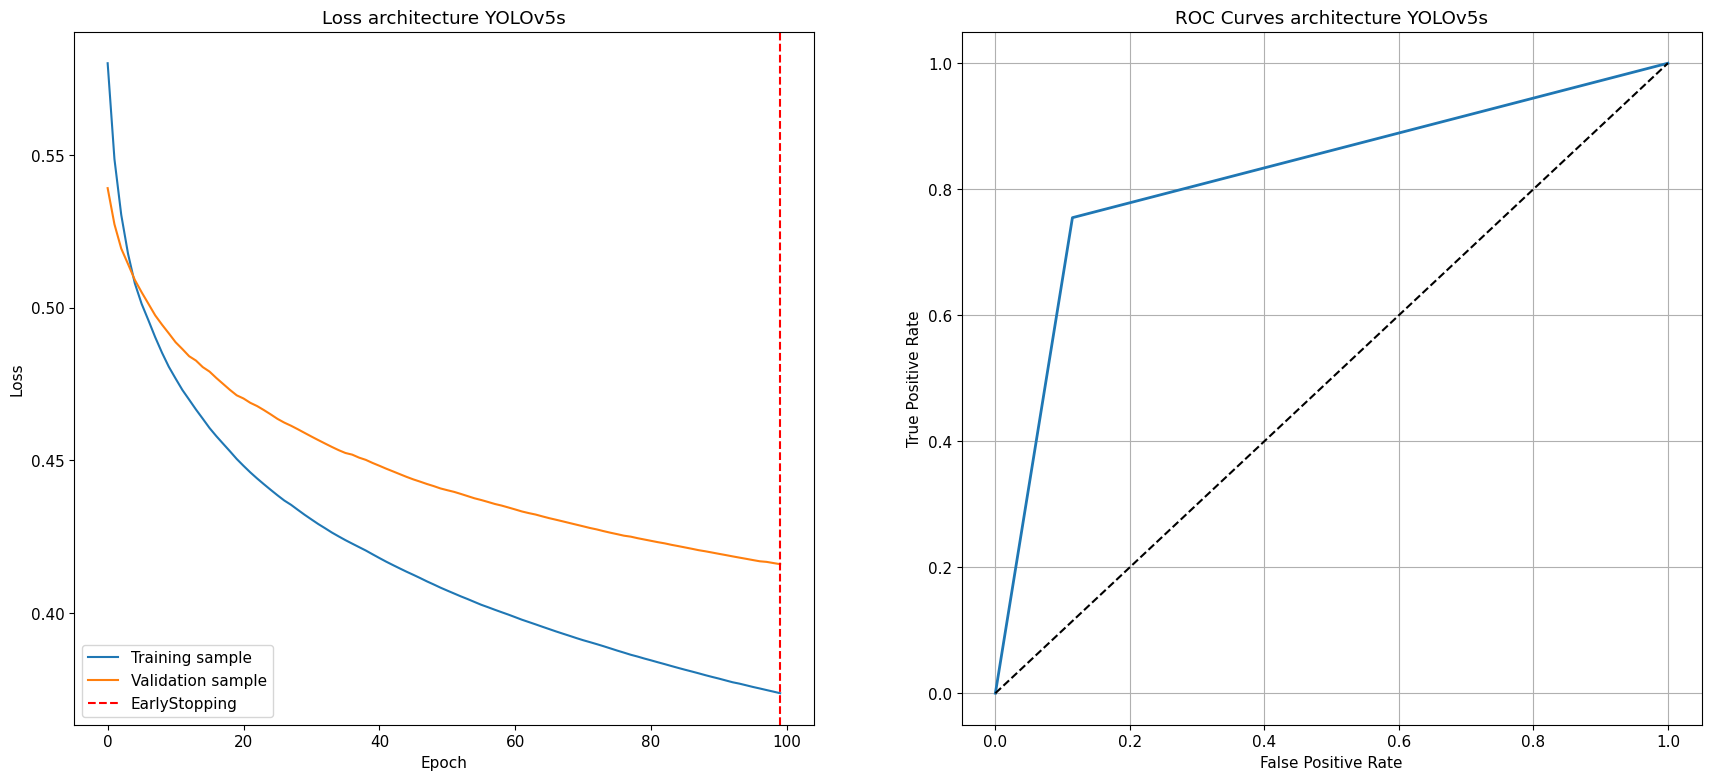

In [19]:
model = torch.hub.load(
    "ultralytics/yolov5", "custom", "yolov5s-cls.pt"
) # Loading structure and weights
model.model.model[-1].linear = torch.nn.Linear(1280, 1) # Prediction layer replacement
model = model.model
model.to(device)
name_model = 'YOLOv5s'
roc, loss_history, epoch_erly_stopping, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del model, loss_history, epoch_erly_stopping, loss, name_model, roc

## 3.7. Training of YOLOv8 neural network architecture



                   from  n    params  module                                       arguments                     

  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 

  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                

  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             

  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                

  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             

  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               

  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           

  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv        

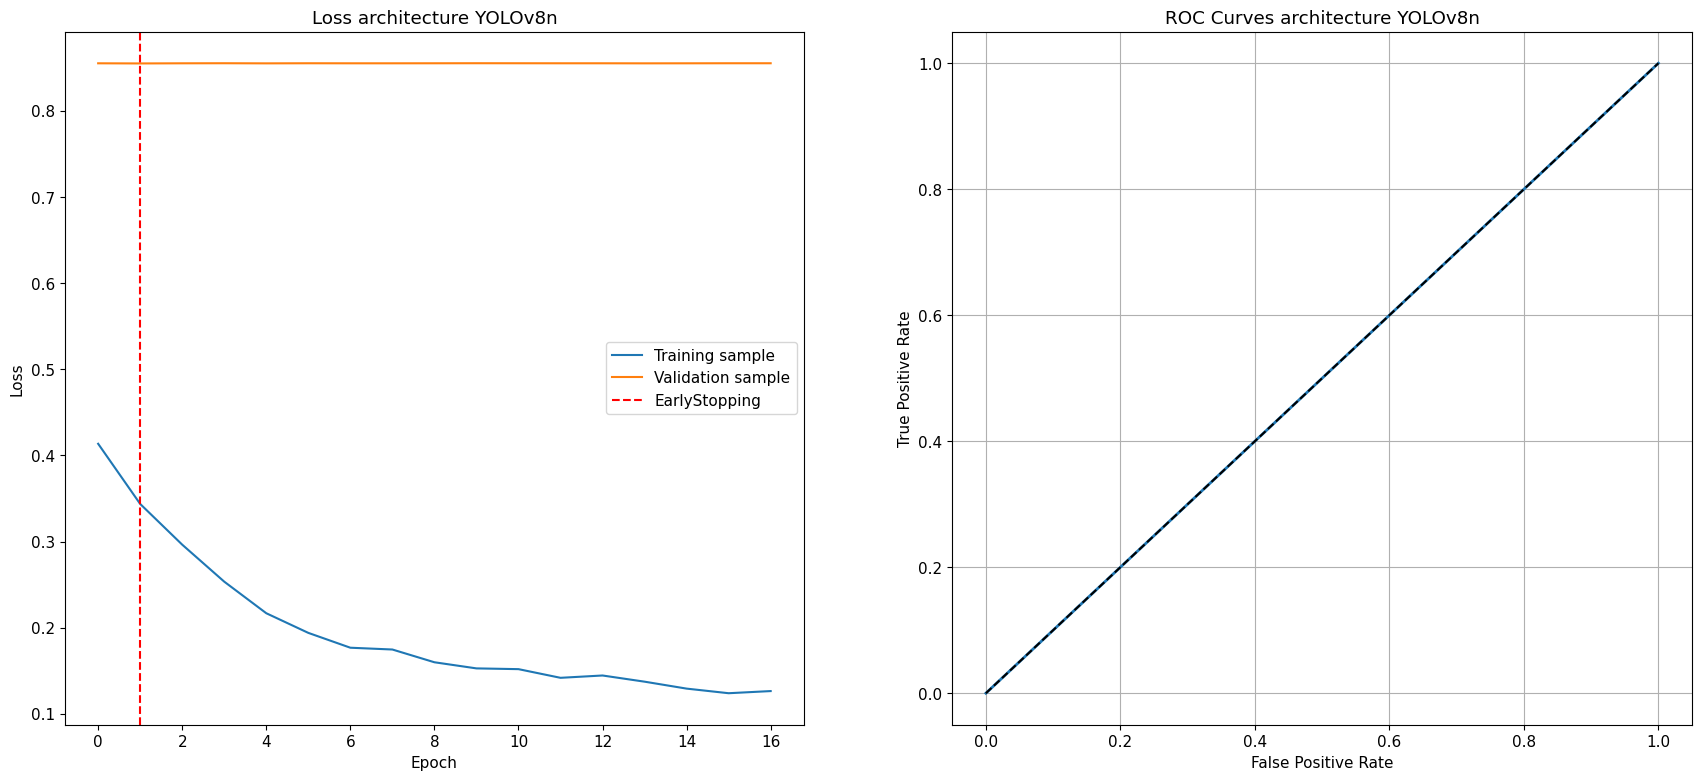

In [20]:
model = YOLO('yolov8n-cls.yaml').load('yolov8n-cls.pt') # Loading structure and weights
model.model.model[-1].linear = torch.nn.Linear(1280, 1) # Prediction layer replacement
model = model.model
model.to(device)
name_model = 'YOLOv8n'
roc, loss_history, epoch_erly_stopping, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del model, loss_history, epoch_erly_stopping, loss, name_model, roc

## 3.8. Training of REGNET_X_1_6GF neural network architectures

Training of RegNet_y_1_6gf neural network architecture

[  1/100] loss train: 0.62695 | loss valid: 0.54149

Validation loss decreased (inf --> 0.54149).  Saving model ...

[  2/100] loss train: 0.55760 | loss valid: 0.55973

EarlyStopping counter: 1 out of 15

[  3/100] loss train: 0.51968 | loss valid: 0.53208

Validation loss decreased (0.54149 --> 0.53208).  Saving model ...

[  4/100] loss train: 0.48303 | loss valid: 0.50232

Validation loss decreased (0.53208 --> 0.50232).  Saving model ...

[  5/100] loss train: 0.45446 | loss valid: 0.46965

Validation loss decreased (0.50232 --> 0.46965).  Saving model ...

[  6/100] loss train: 0.42495 | loss valid: 0.46971

EarlyStopping counter: 1 out of 15

[  7/100] loss train: 0.39819 | loss valid: 0.44540

Validation loss decreased (0.46965 --> 0.44540).  Saving model ...

[  8/100] loss train: 0.37269 | loss valid: 0.42231

Validation loss decreased (0.44540 --> 0.42231).  Saving model ...

[  9/100] loss train: 0.35010 | loss valid: 

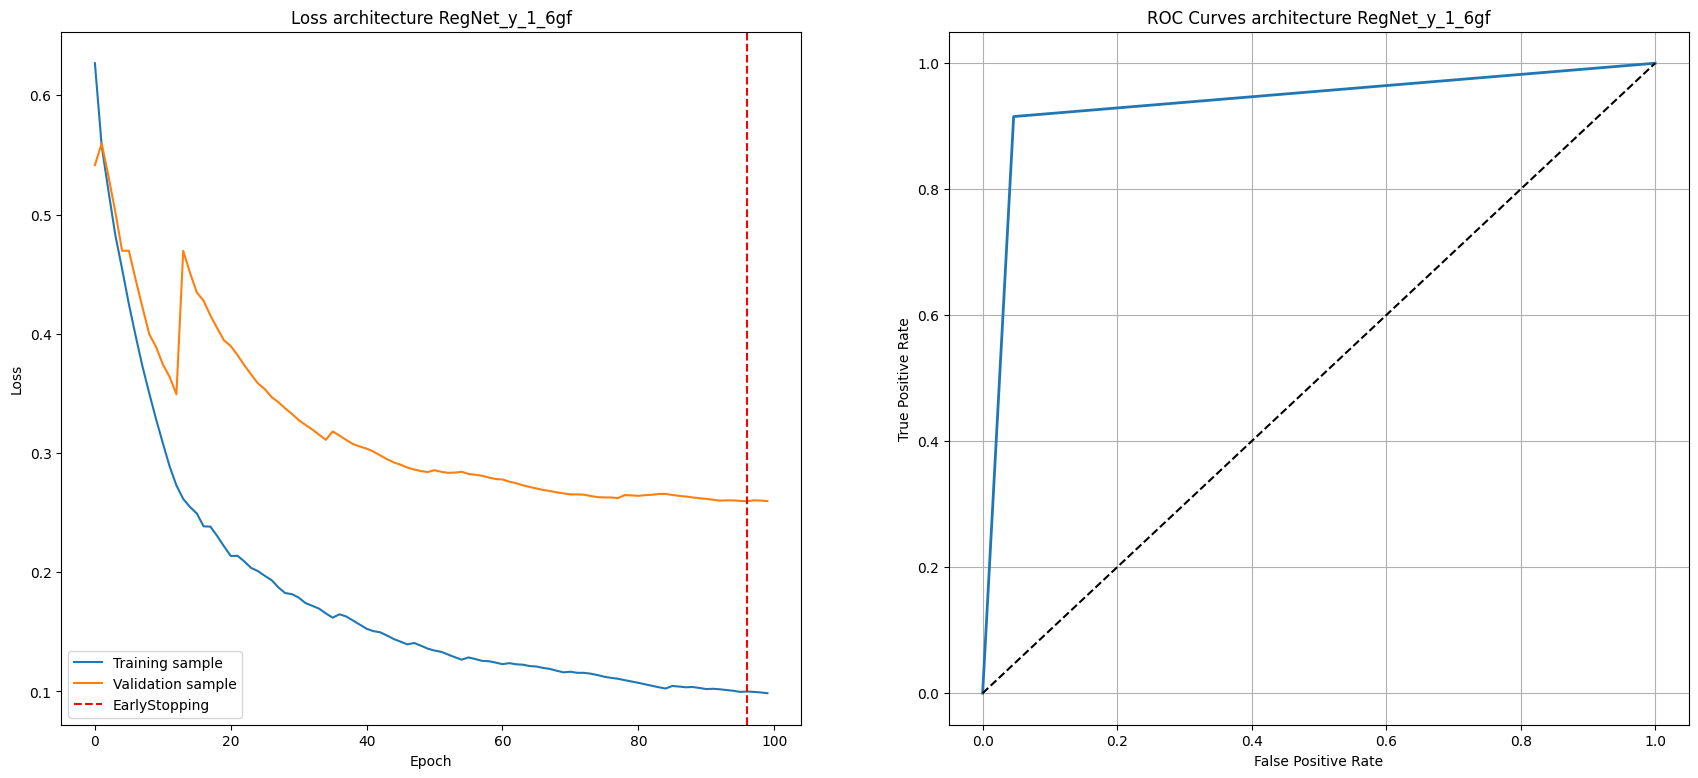

In [21]:
model = models.regnet_y_1_6gf() # Loading structure and weights
model.fc = torch.nn.Linear(888, 1) # Prediction layer replacement
model.to(device)
name_model = 'RegNet_y_1_6gf'
roc, loss_history, epoch_erly_stopping, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del model, loss_history, epoch_erly_stopping, loss, name_model, roc

## 3.9 Visualize all models on one graph

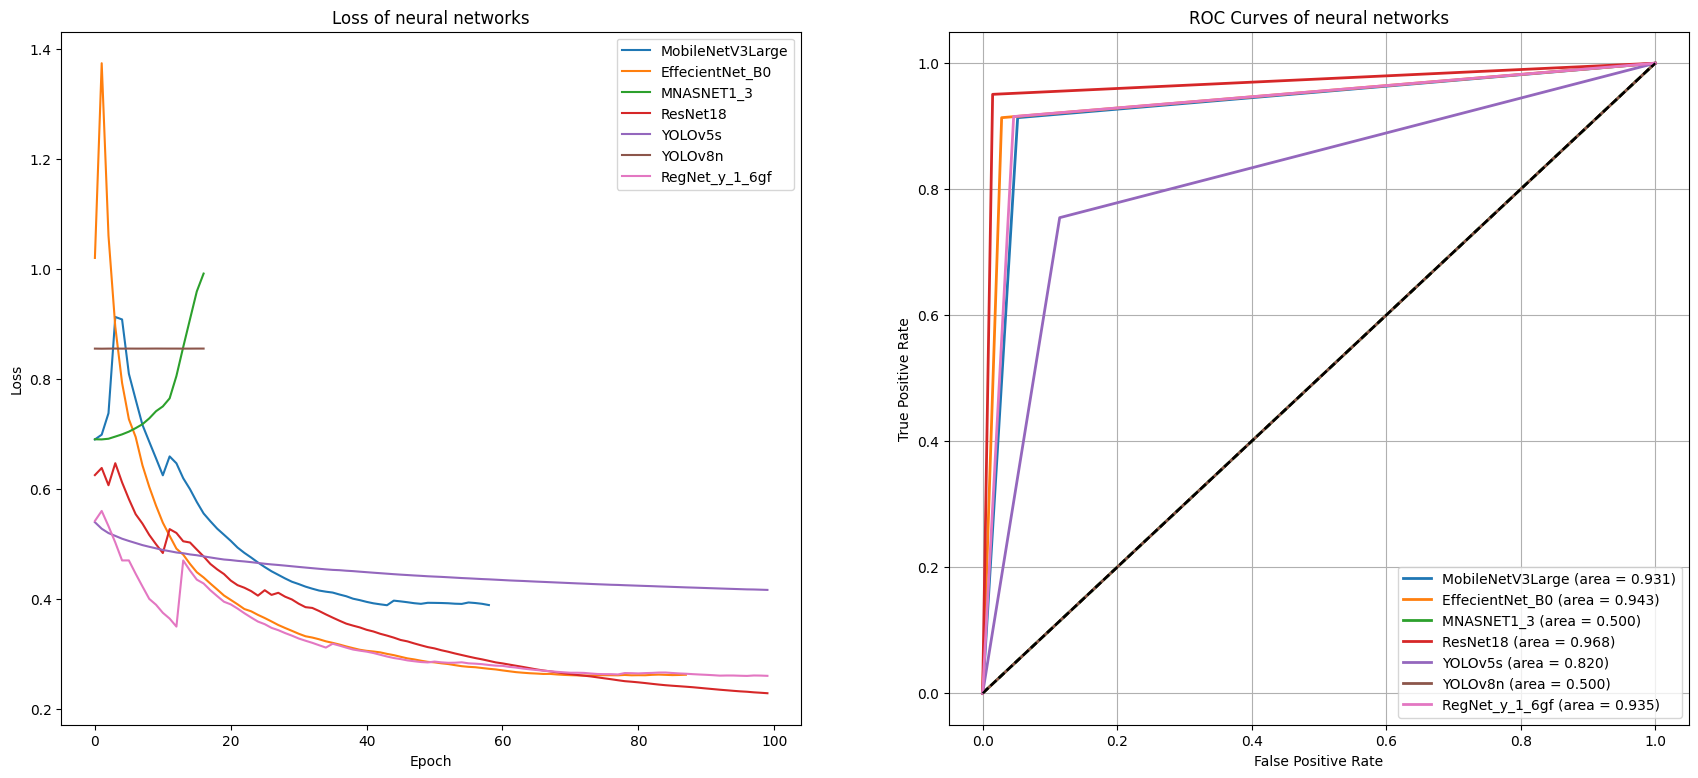

In [22]:
with open('data.json', 'r') as file:
    data = json.load(file)
visualizationNeuralNetworks(data[:7])

From the outcome of neural network training, it can be seen that the ResNet architecture has better performance on the ROC curve

# 4. Exploring different versions of the ResNet architecture
## 4.1. Training the ResNet34 architecture

Training of ResNet34 neural network architecture

[  1/100] loss train: 0.62962 | loss valid: 0.64700

Validation loss decreased (inf --> 0.64700).  Saving model ...

[  2/100] loss train: 0.56821 | loss valid: 1.01821

EarlyStopping counter: 1 out of 15

[  3/100] loss train: 0.53766 | loss valid: 0.90494

EarlyStopping counter: 2 out of 15

[  4/100] loss train: 0.51193 | loss valid: 0.79872

EarlyStopping counter: 3 out of 15

[  5/100] loss train: 0.49344 | loss valid: 0.71974

EarlyStopping counter: 4 out of 15

[  6/100] loss train: 0.47814 | loss valid: 0.75570

EarlyStopping counter: 5 out of 15

[  7/100] loss train: 0.47755 | loss valid: 0.77335

EarlyStopping counter: 6 out of 15

[  8/100] loss train: 0.47059 | loss valid: 0.73535

EarlyStopping counter: 7 out of 15

[  9/100] loss train: 0.46034 | loss valid: 0.69311

EarlyStopping counter: 8 out of 15

[ 10/100] loss train: 0.45107 | loss valid: 0.65804

EarlyStopping counter: 9 out of 15

[ 11/100] loss train: 0.44119 | 

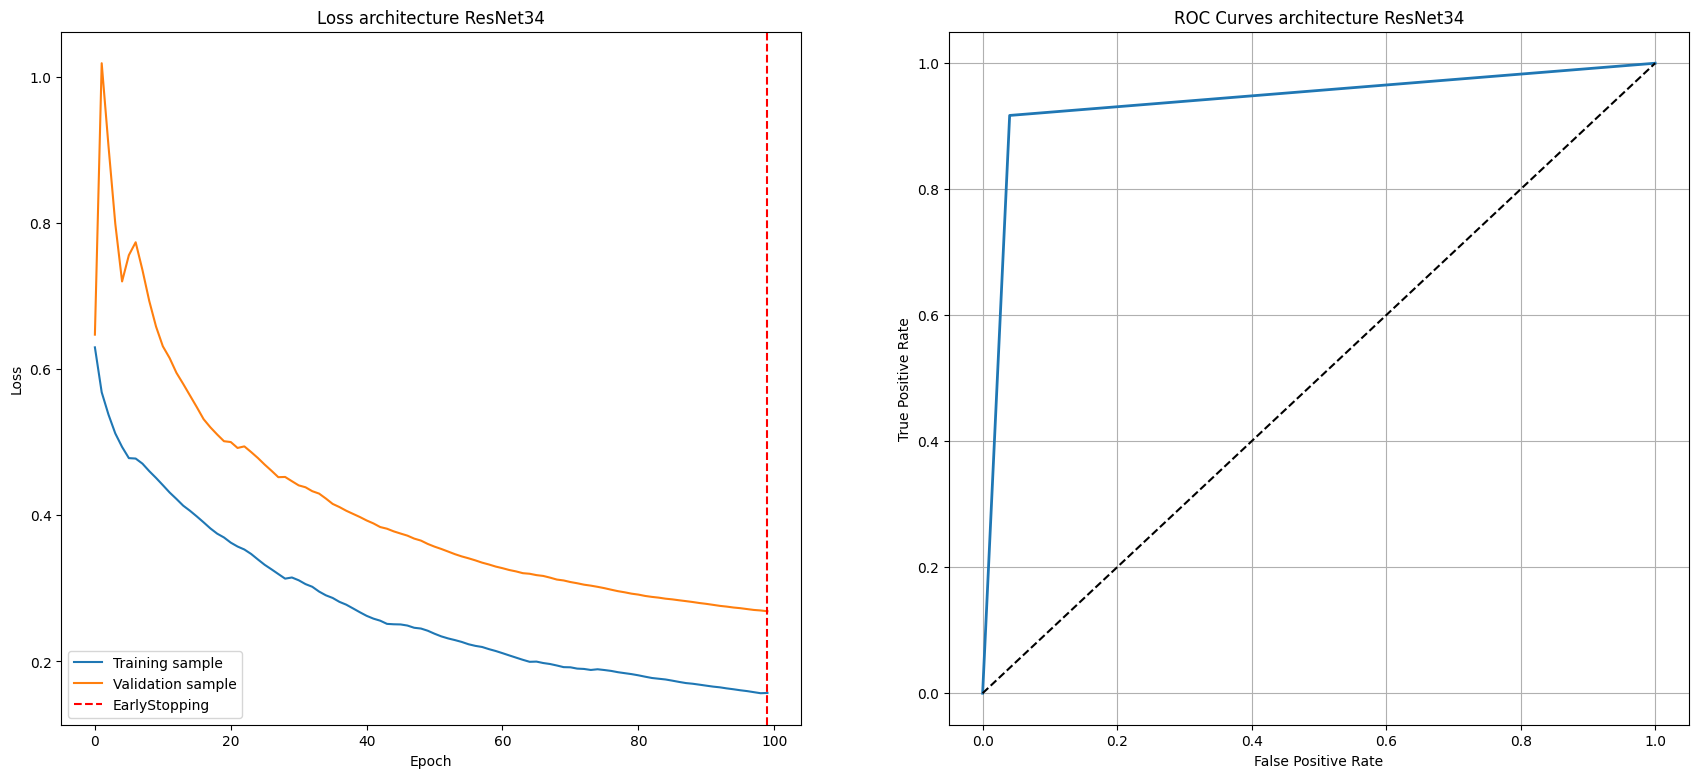

In [23]:
model = models.resnet34() # Loading structure and weights
model.fc = torch.nn.Linear(512, 1) # Prediction layer replacement
model.to(device)
name_model = 'ResNet34'
roc, loss_history, epoch_erly_stopping, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del model, loss_history, epoch_erly_stopping, loss, name_model, roc

## 4.2. Training the ResNet50 architecture

Training of ResNet50 neural network architecture

[  1/100] loss train: 0.75978 | loss valid: 6.31189

Validation loss decreased (inf --> 6.31189).  Saving model ...

[  2/100] loss train: 0.64859 | loss valid: 3.42634

Validation loss decreased (6.31189 --> 3.42634).  Saving model ...

[  3/100] loss train: 0.59215 | loss valid: 2.44706

Validation loss decreased (3.42634 --> 2.44706).  Saving model ...

[  4/100] loss train: 0.54944 | loss valid: 1.98253

Validation loss decreased (2.44706 --> 1.98253).  Saving model ...

[  5/100] loss train: 0.51395 | loss valid: 1.69801

Validation loss decreased (1.98253 --> 1.69801).  Saving model ...

[  6/100] loss train: 0.48779 | loss valid: 1.49582

Validation loss decreased (1.69801 --> 1.49582).  Saving model ...

[  7/100] loss train: 0.46811 | loss valid: 1.34969

Validation loss decreased (1.49582 --> 1.34969).  Saving model ...

[  8/100] loss train: 0.44565 | loss valid: 1.22604

Validation loss decreased (1.34969 --> 1.22604).  Savi

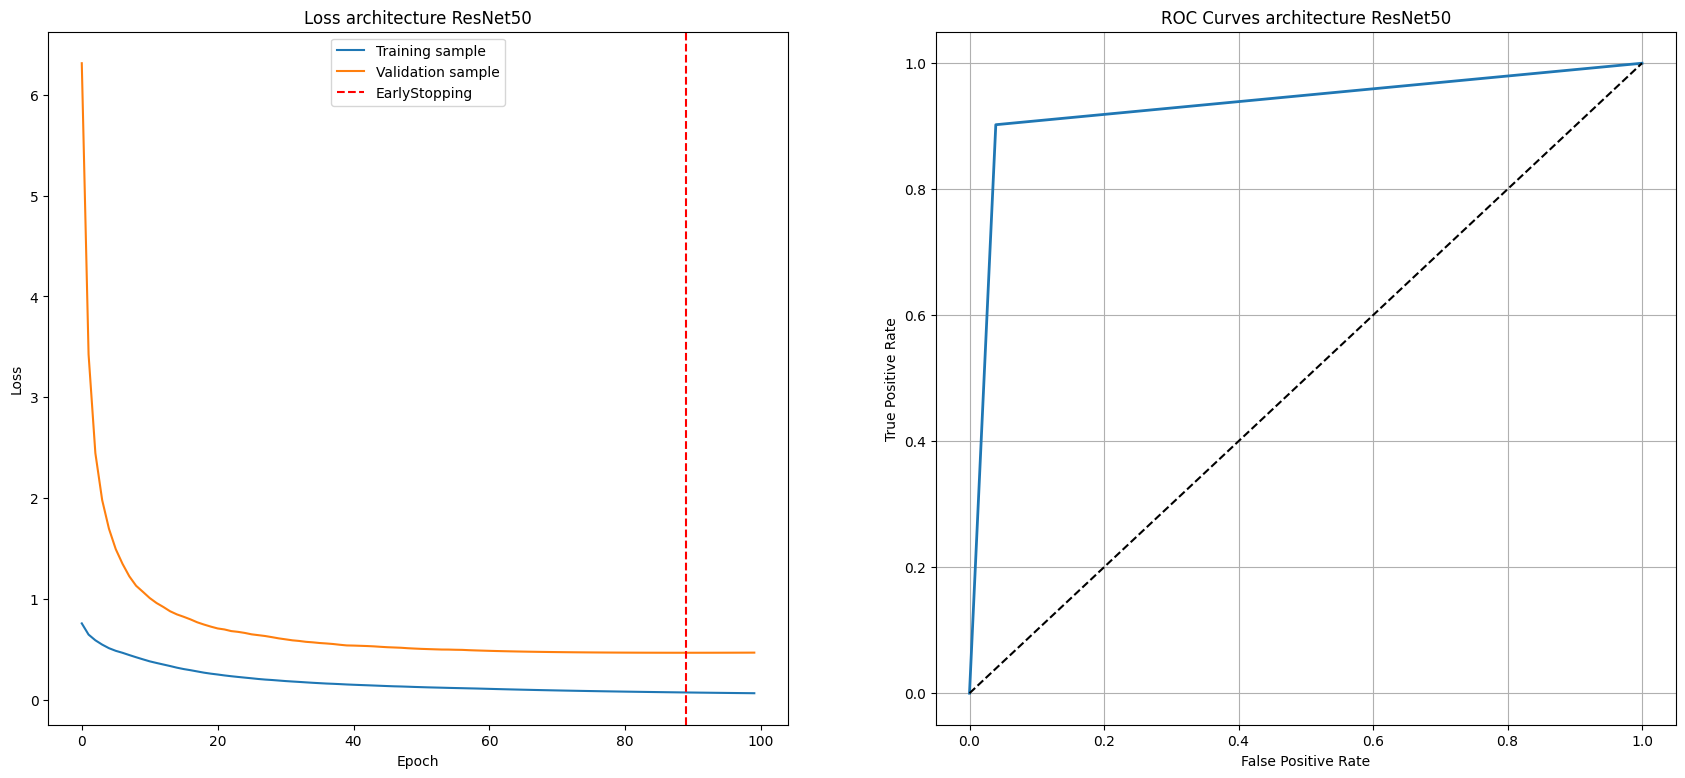

In [24]:
model = models.resnet50() # Loading structure and weights
model.fc = torch.nn.Linear(2048, 1) # Prediction layer replacement
model.to(device)
name_model = 'ResNet50'
roc, loss_history, epoch_erly_stopping, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del model, loss_history, epoch_erly_stopping, loss, name_model, roc

## 4.3. Visualization of ResNet architecture version training results

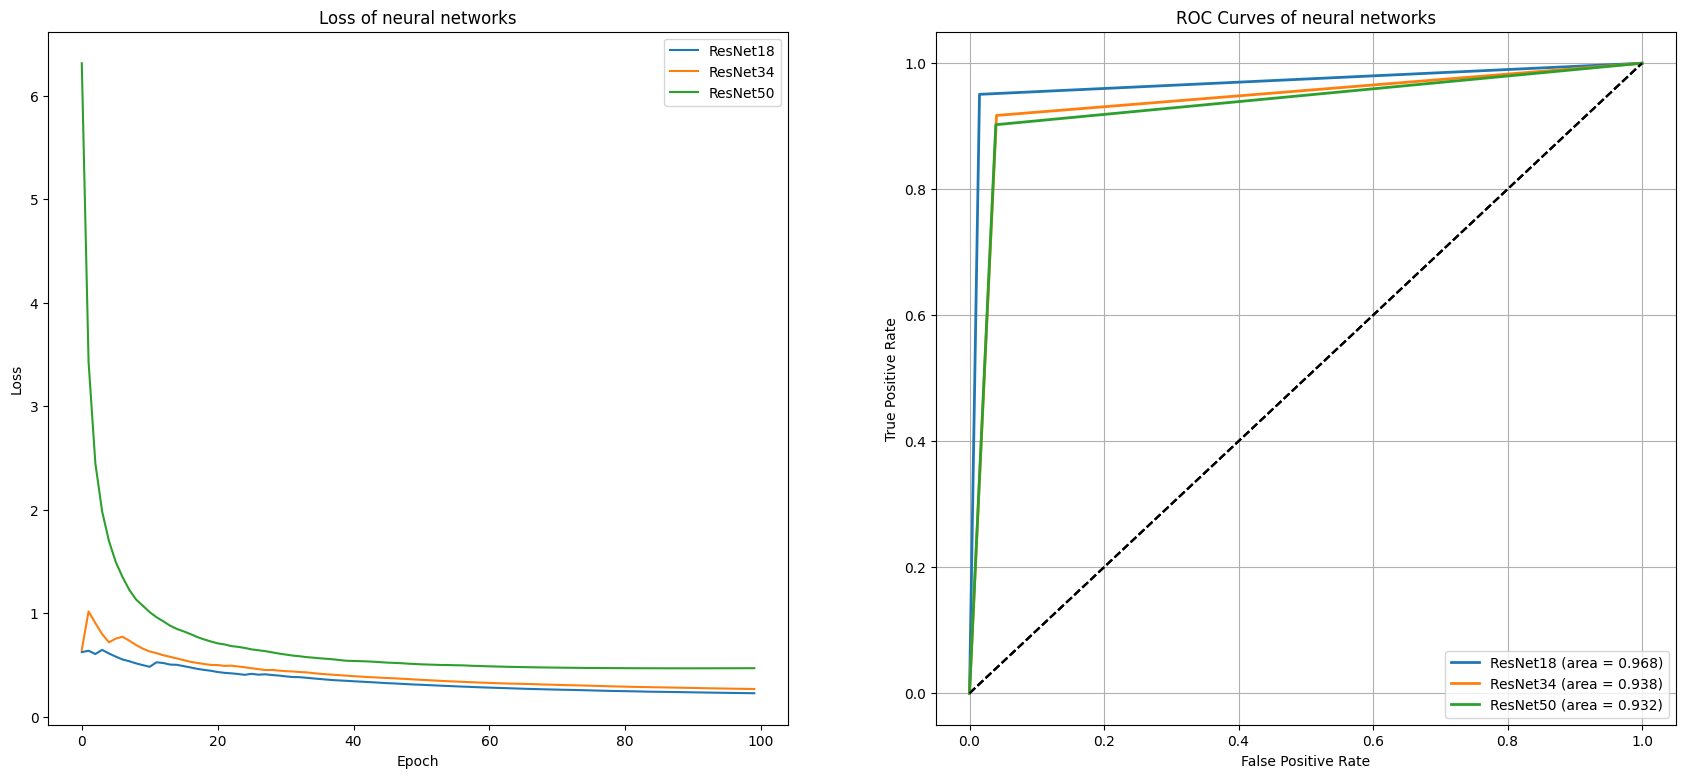

In [25]:
with open('data.json', 'r') as file:
    data = json.load(file)
resnet_data = []
for index in range(len(data)):
    if data[index]['name'].find('ResNet') != -1:
        resnet_data.append(data[index])
visualizationNeuralNetworks(resnet_data, isEnhancement='VisualizationResNetVersion')
del data, resnet_data

According to the training results of different versions of the ResNet neural network architecture, the ResNet18 version has the best performance 

# 5. Learning the best architecture for neroset
## 5.1. Let's apply all augmentations to images

100%|██████████████████████████████████████████████████████████████████████████████| 1625/1625 [00:36<00:00, 44.80it/s]


CPU times: total: 30.7 s

Wall time: 1min 15s


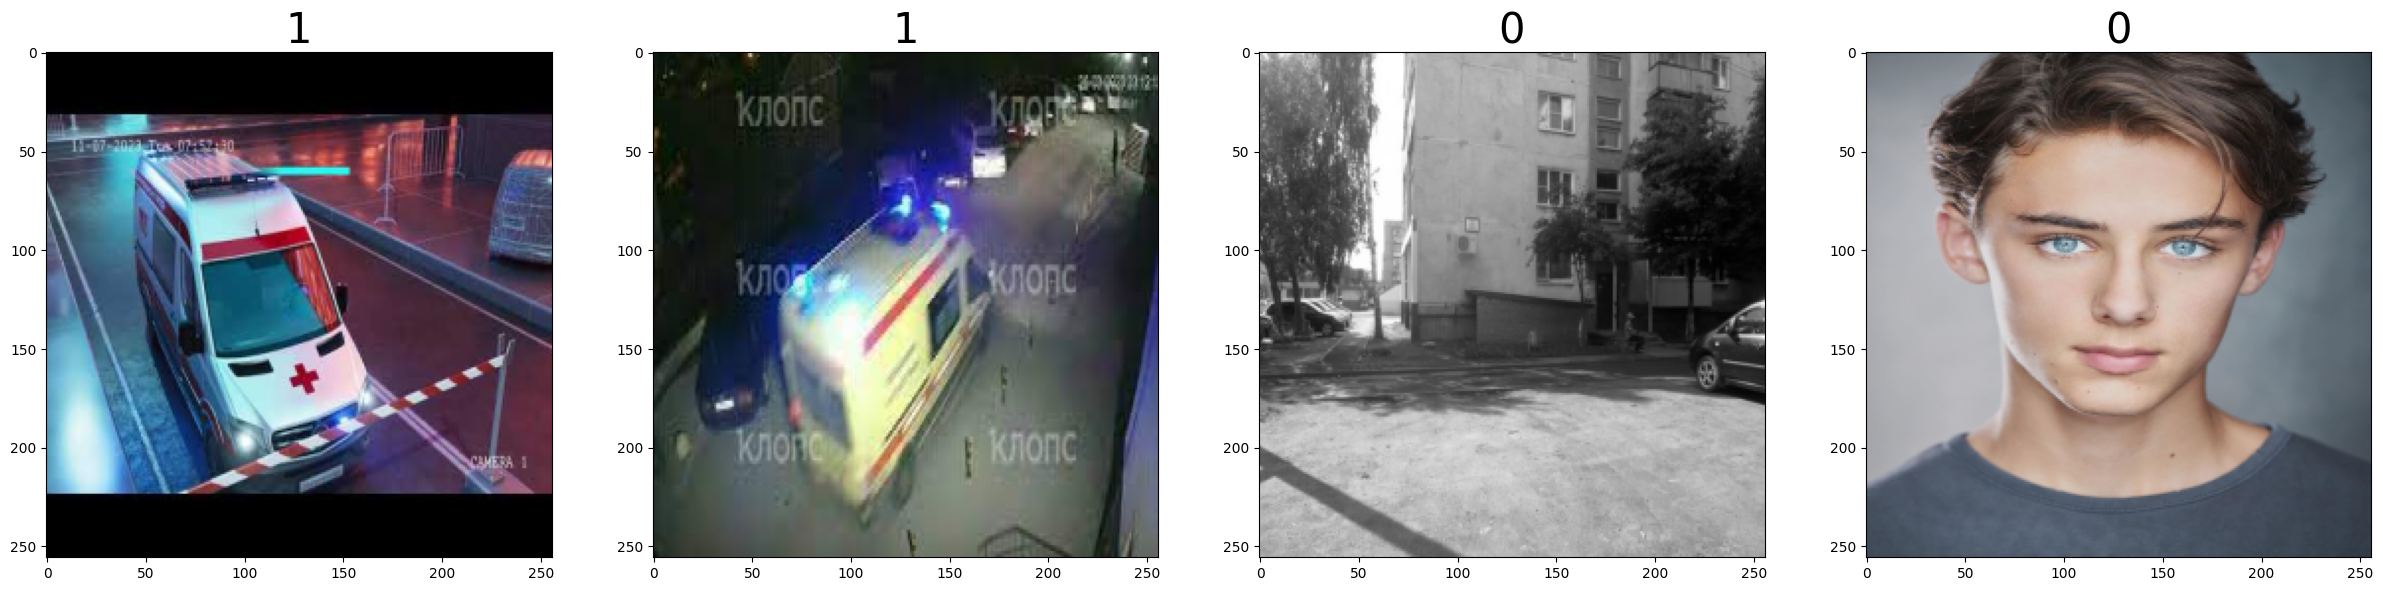

In [26]:
%%time
X = [] # Photographs in matrix format
y = [] # Classes of photographs
for i in tqdm(range(len(data))):
    image = data.loc[i,'src'] # Get the path to the image
    if (data.loc[i, 'label'] == 1): # If there's a special car in the picture
        image = cv2.imread('./Dataset/Spesial_car/'+image, cv2.IMREAD_COLOR) 
    else: # If it's not a special car in the picture
        image = cv2.imread('./Dataset/Rest/'+image, cv2.IMREAD_COLOR) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert the color palette of the photo from BGR to RGB 
    image = cv2.resize(image, dsize=(256, 256), interpolation=cv2.INTER_AREA) # Resize the image
    X.append(image) # Add to the dataset
    # We're augmenting the photos
    for transform in [transform1, transform2, transform3, transform4]:
        transformed_image = transform(image=image)
        X.append(transformed_image["image"])
    # Add labels for images
    for _ in range(5):
        y.append(data.loc[i, 'label'])

# Normalize the data
X_torch = np.array(X)
X_torch = X_torch.astype('float32')
X_torch = X_torch / 255.0
X_torch = X_torch.reshape(-1,3, 256, 256)
y_torch = np.array(y).reshape(-1)

# Let's take a couple of examples of the resulting photos
fig, axes = plt.subplots(1, 4, figsize=(30,15))
for i in range(0, 4):
    axes[i].imshow(X[i*y_torch.size//4])
    axes[i].set_title(y[i*y_torch.size//4], fontsize=30)

In [27]:
print(f"Number of Isorations: {X_torch.shape[0]} | Number of tags {y_torch.size}")
print(f"The number of photos after augmentation increased {round(y_torch.size / data.shape[0], 3)} times to {y_torch.size} images") 

Количество изоражений: 8125 | Количество меток 8125

Количество фотографий после аугментации увеличилось в 5.0 раз и составило 8125 изображения


## 5.2. Formation of training and validation sample, translation of data into tensors.

In [28]:
# Form a new training and test sample
X_train, X_valid, y_train, y_valid = train_test_split(X_torch, y_torch, random_state=42)
# Let's convert all the data into tensors
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train)
X_valid_t = torch.from_numpy(X_valid).float()
y_valid_t = torch.from_numpy(y_valid)

# Generate datasets with samples
train_dataset = TensorDataset(X_train_t, y_train_t)
valid_dataset = TensorDataset(X_valid_t, y_valid_t)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

# Dictionary with selections
loaders = {"train": train_dataloader, "valid": valid_dataloader}

## 5.3. Training the best version of the neural network

Training of ResNet18-top neural network architecture

[  1/350] loss train: 0.24122 | loss valid: 0.09826

Validation loss decreased (inf --> 0.09826).  Saving model ...

[  2/350] loss train: 0.15063 | loss valid: 0.09946

EarlyStopping counter: 1 out of 25

[  3/350] loss train: 0.11053 | loss valid: 0.09767

Validation loss decreased (0.09826 --> 0.09767).  Saving model ...

[  4/350] loss train: 0.08887 | loss valid: 0.10692

EarlyStopping counter: 1 out of 25

[  5/350] loss train: 0.07851 | loss valid: 0.10641

EarlyStopping counter: 2 out of 25

[  6/350] loss train: 0.06845 | loss valid: 0.10413

EarlyStopping counter: 3 out of 25

[  7/350] loss train: 0.06375 | loss valid: 0.10074

EarlyStopping counter: 4 out of 25

[  8/350] loss train: 0.05676 | loss valid: 0.09567

Validation loss decreased (0.09767 --> 0.09567).  Saving model ...

[  9/350] loss train: 0.05093 | loss valid: 0.09383

Validation loss decreased (0.09567 --> 0.09383).  Saving model ...

[ 10/350] loss train:

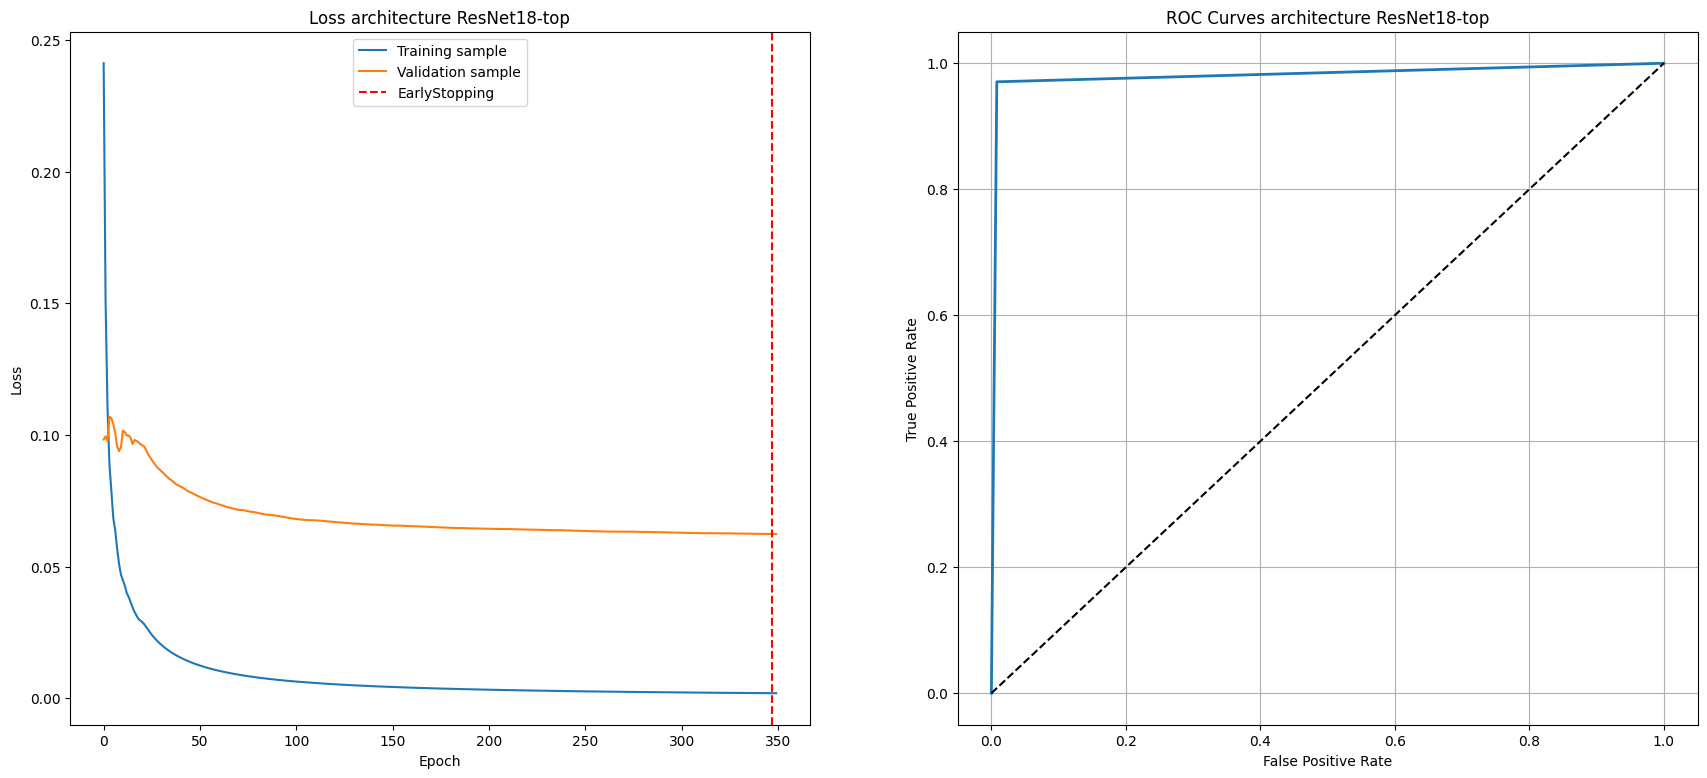

In [29]:
max_epochs_models = 350 # Maximum number of epochs
epoch_patience_models = 25 # The tolerance of the ages to an early halt
model = models.resnet18(pretrained=True) # Loading structure and weights pretrained model
model.fc = torch.nn.Linear(512, 1) # Prediction layer replacement
model.to(device)
name_model = 'ResNet18-top'
roc, loss_history, epoch_erly_stopping, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models, lr=0.0001)
addHistoryModels(name_model, roc, loss_history, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del model, loss_history, epoch_erly_stopping, loss, name_model, roc

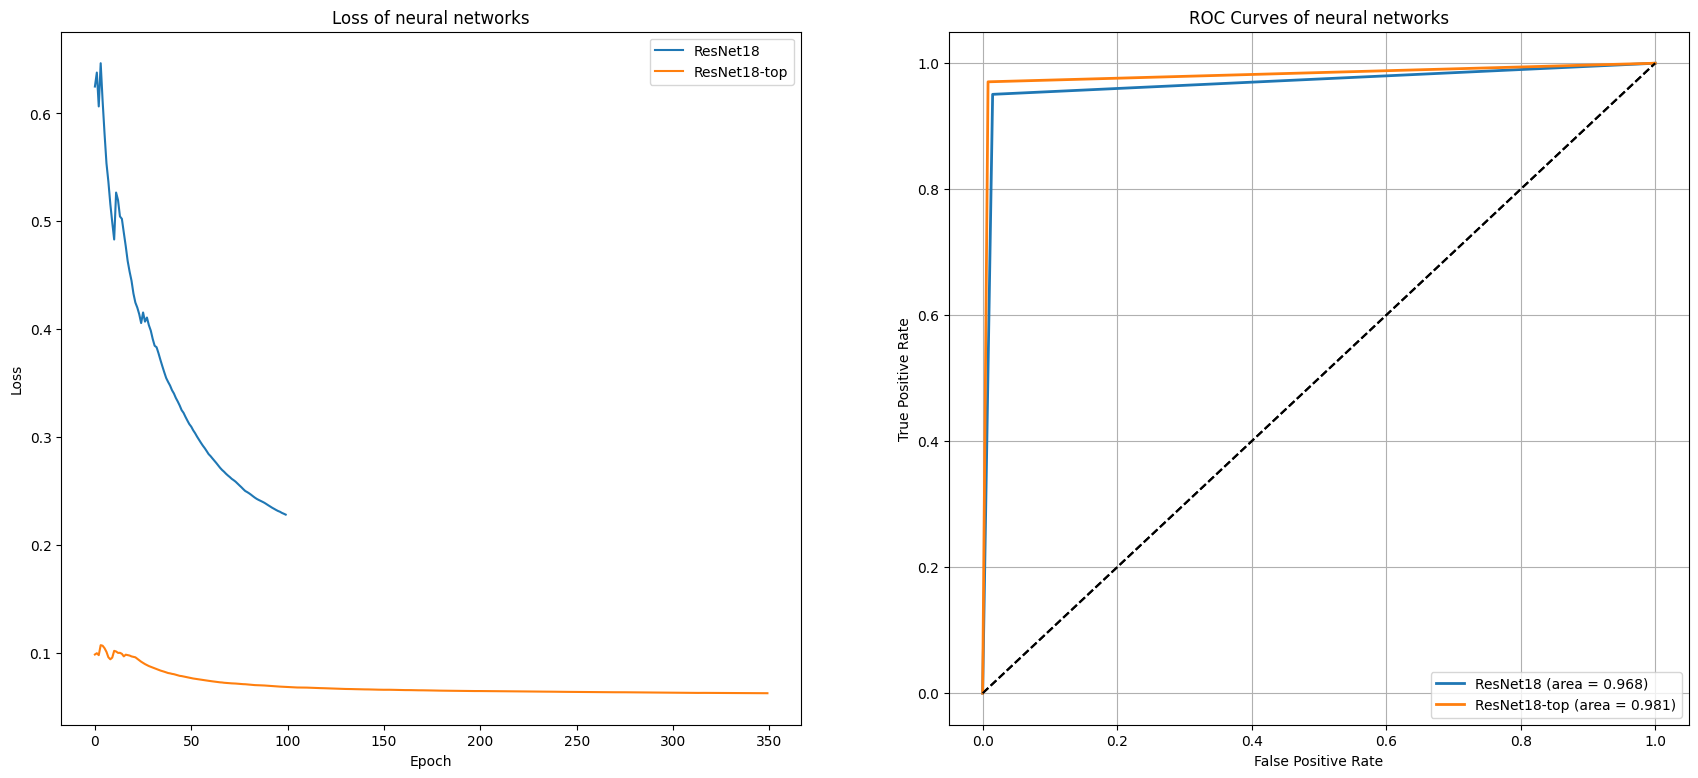

In [30]:
with open('data.json', 'r') as file:
    data = json.load(file)
resnet_data = []
for index in range(len(data)):
    if data[index]['name'].find('ResNet18') != -1:
        resnet_data.append(data[index])
visualizationNeuralNetworks(resnet_data, isEnhancement='VisualizationTratingResNet18')
del data, resnet_data

As a result of applying full augmentation to all images, we were able to improve the performance of the neural network.